Here we show how to use a trained VAE to make a recommendation of a new molecule based on some given reference molecules. The architecture we used is JTVAE (https://arxiv.org/abs/1802.04364). It is a VAE which generates a new molecule in 2 stages. In the first stage, a coarse view of the molecule is generated by assembing a tree representation of the molecule, where each node in the tree is a chemical substructure, and an edge indicates that at least one of the atoms in each substructure share a bond. These structures are selected from a vocabulary of valid chemical structures, which ensures that the overall generated molecule is chemically valid. In the second stage, the finer details of the molecule are resolved by generating the bonds between atoms in neighboring substructures.

![Training metrics.](../paradigm.png)

Since there are 2 stages, there are two latent vectors per molecule, one for the tree structure and one for the bonds. Given these two vectors for each of the reference molecules, we get each latent vectors for the new molecule by averaging over the latent vectors for the reference molecules. We then generate the recommended molecule by passing the averaged latent vectors to the decoder of the VAE.

# VAE

A VAE is a type of autoencoder which enforces normality on the latent vectors. During training, given an input $x$, the encoder $\mathcal E$ maps $x$ to a $d$-dimensional normal distribution as $\mathcal E(x)=(\mu_z,\sigma_z)$, where $\mu_z,\sigma_z\in\mathbb R^d$. The VAE then samples the latent vector $z\sim\mathcal N(\mu_z,\operatorname{diag}(\sigma_z))$. Finally, the decoder $\mathcal D$ decodes $z$ back to something which is hopefully close to $x$.

The purpose of sampling the latent $z$ from a normal distribution instead of just having the encoder output it directly as $\mathcal E(x)=z$ like in a regular autoencoder is so that the VAE can be used later on to generate new samples which look like the training data. The VAE is trained with an extra loss term such that $\mu_z\approx \mathbf{0}\in\mathbb R^d$ and $\sigma_z\approx \mathbf{1}\in\mathbb R^d$, which means that $z$ will be approximately distributed $\mathcal N(\mathbf{0},\mathbf{I}^{d\times d})$. To generate a new sample, a trained VAE can then take a $z$ sampled randomly from $\mathcal N(\mathbf{0},\mathbf{I}^{d\times d})$ and decode it. 

There are two terms in the VAE objective. The first is the reconstruction loss, which ensures that the decoder is able to recover the input $x$ from the latent $z$. The second is the KL divergence, which is to encourage the distribution of $z$ to be approximately distributed $\mathcal N(\mathbf{0},\mathbf{I}^{d\times d})$. The overall loss is given by 
$$
\operatorname{reconstruction\:loss} + \beta\cdot \operatorname{KL},
$$
where $\beta$ weights the KL divergence. Note that the KL divergence and the reconstruction loss are at odds with one another. The minimizer of the reconstruction loss is when the model sets $\sigma_z$ to be $\mathbf{0}^d$, because randomness will make it harder for the decoder to reconstruct the input, and 0 variance means all of the randomness in the latent $z$ is gone such that $z=\mu_z$. Also, forcing $\mu_z$ to be $\mathbf{0}^d$ for all $x$ will make it so that it is impossible to reconstruct any of the inputs, since all of their latent representations would look identical to the decoder.

We therefore trained 2 models -- 1 of them leaves $\beta=0$, while the other is trained with $\beta$ as large as $0.01$. Below are the training metrics -- `assm`, `topo`, and `word` are reconstruction accuracies. $\beta>0$ hurts the reconstruction performance, but it reduces the KL since the latent distributions are closer to $\mathcal N(\mathbf{0}^d,\mathbf{I}^{d\times d})$.

![Training metrics.](../saved_models/tb.png)

When using the decoder for generation, the sampling temperature $\tau$ can be varied. Temperature is used to control how likely under the training distribution newly generated samples are. Instead of sampling $z\sim\mathcal N(\mathbf{0},\mathbf{I}^{d\times d})$, $z$ is sampled from $\mathcal N(\mathbf{0},\tau\mathbf{I}^{d\times d})$. Larger $\tau$ mean that the generated sample will be less likely under the training distribution -- this can be a good thing for increasing the novelty of generated samples. 

In [1]:
import sys
sys.path.append('..')
from fast_jtnn import *
import torch, rdkit, os
from rdkit import Chem
from tqdm import tqdm
from fast_molvae.preprocess import tensorize
rdkit.RDLogger.DisableLog('rdApp.*')
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Here's a script for creating a `conda` environment: https://github.com/yyctamu/CHEMIR/blob/main/GNN/setup.sh. Maintaining the same RDKit version may or may not be important. Newer versions create much nicer visualizations, but early on, I was getting a `RDKit::KekulizeException` with newer versions. I am not sure if this exception will still be an issue with the current version of the code. If it is, we can use a newer version to visualize the generated SMILES.

In [2]:
torch.__version__, rdkit.__version__ 


('2.2.1', '2020.09.5')

In [3]:
# load the training data smiles
train_path = "../data/zinc/train.txt"
with open(train_path) as f:
    smiles = [line.strip("\r\n ").split()[0] for line in f]
len(smiles), smiles[:5]

(220011,
 ['CCCCCCC1=NN2C(=N)/C(=C\\c3cc(C)n(-c4ccc(C)cc4C)c3C)C(=O)N=C2S1',
  'COCC[C@@H](C)C(=O)N(C)Cc1ccc(O)cc1',
  'C=CCn1c(S[C@H](C)c2nc3sc(C)c(C)c3c(=O)[nH]2)nnc1C1CC1',
  'C[NH+](C/C=C/c1ccco1)CCC(F)(F)F',
  'COc1ccc(N2C(=O)C(=O)N(CN3CCC(c4nc5ccccc5s4)CC3)C2=O)cc1'])

In [4]:
# smiles which were held out as testing data
test_path = "../data/zinc/test.txt"
with open(test_path) as f:
    test_smiles = [line.strip("\r\n ").split()[0] for line in f]
len(test_smiles), test_smiles[:5]

(5000,
 ['CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1',
  'C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1',
  'N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)cc2)cc1',
  'CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c2CCCCC3)C1',
  'N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#N)C12CCCCC2'])

In [5]:
# load the vocabulary of valid chemical structures
vocab_path = "../data/zinc/new_vocab.txt"
vocab = [x.strip("\r\n ") for x in open(vocab_path)] 
vocab = Vocab(vocab)
len(vocab.vocab), vocab.vocab[:5]

(755, ['C1=CNCCC1', 'C1=CCCOCC1', 'C1CNPOC1', 'C1=COCO1', 'C1CC2CC(C1)C2'])

In [6]:
# load saved models
model_path = "../saved_models"
state_dict0 = torch.load(os.path.join(model_path, 'max_beta0.pt'), map_location='cpu')
state_dict0_01 = torch.load(os.path.join(model_path, 'max_beta0.01.pt'), map_location='cpu')
hidden_size = 450
latent_size = 56
depthT = 20
depthG = 3
torch.manual_seed(1)
new_model = JTNNVAE(vocab, hidden_size, latent_size, depthT, depthG)
model0 = JTNNVAE(vocab, hidden_size, latent_size, depthT, depthG)
model0.load_state_dict(state_dict0)
model0_01 = JTNNVAE(vocab, hidden_size, latent_size, depthT, depthG)
model0_01.load_state_dict(state_dict0_01)
new_model.eval().to(device), model0.eval().to(device), model0_01.eval().to(device)
print('loaded.')

/data5/jacob/anaconda3/envs/ir/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


loaded.


In [7]:
# function for drawing a sample from the latent distribution
def rsample(z_vecs, W_mean, W_var, temp=1, return_stats=False):
    batch_size = z_vecs.size(0)

    # get the mean and variance
    z_mean = W_mean(z_vecs)
    z_log_var = -torch.abs(W_var(z_vecs)) #Following Mueller et al.
    kl_loss = -0.5 * torch.sum(1.0 + z_log_var - z_mean * z_mean - torch.exp(z_log_var)) / batch_size
    epsilon = temp * nnutils.create_var(torch.randn_like(z_mean))
    z_var = torch.exp(z_log_var / 2)

    # z_vecs is distributed normally with mean z_mean and variance z_var
    z_vecs = z_mean + z_var * epsilon
    stats = [z_mean, z_var] if return_stats else None        
    return z_vecs, stats

In [8]:
# function for molecule reconstruction
# 
# smile is a single smiles string to be reconstructed
# seed is a random seed
# temp is the sampling temperature
def reconstruct(model, smile: str, seed: int, temp: float, print_stats: bool):
  model.eval()
  with torch.no_grad():
    if seed is not None:
      torch.manual_seed(seed)
    
    # y is the vector which determines the latent distributions 
    y = model.encode_from_smiles([smile])

    # draw sample from latent distributions (z_tree_vecs and z_mol_vecs)
    tree_vecs, mol_vecs = y.chunk(2, dim=1)
    z_tree_vecs,tree_stats = rsample(tree_vecs, model.T_mean, model.T_var, temp, print_stats)
    z_mol_vecs,mol_stats = rsample(mol_vecs, model.G_mean, model.G_var, temp, print_stats)

    # pass the sample through the decoder
    generated_smile = model.decode(z_tree_vecs, z_mol_vecs, prob_decode=False)
    if print_stats:
      prec = 3
      tree_stats = tree_stats[0].abs().mean(), tree_stats[1].mean()
      mol_stats = mol_stats[0].abs().mean(), mol_stats[1].mean()
      print("--- Summary statistics for latent distributions ---")
      print(f"Tree latents: average mean={tree_stats[0]:.{prec}f}, average variance={tree_stats[1]:.{prec}f}")
      print(f"Mol latents: average mean={mol_stats[0]:.{prec}f}, average variance={mol_stats[1]:.{prec}f}")
    return generated_smile

We next use the model to reconstruct the following molecule:

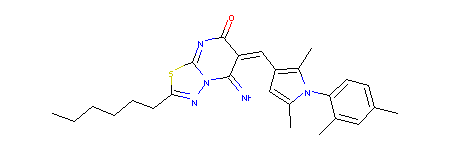

In [9]:
smile_idx = 0
Chem.MolFromSmiles(smiles[smile_idx])

First, we show that the untrained model with randomly initialized weights cannot correctly reconstruct the molecule:

--- Summary statistics for latent distributions ---
Tree latents: average mean=0.149, average variance=0.924
Mol latents: average mean=0.072, average variance=0.958


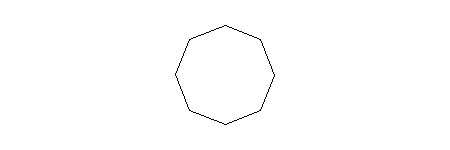

In [10]:
Chem.MolFromSmiles(reconstruct(model=new_model, smile=smiles[smile_idx], seed=1, temp=1, print_stats=True))

The trained models do a perfect job. We also print out the mean and variance for the latent distributions. Note that for the model trained with $\beta=0$, the mean and variances are far from (0, 1), which is to be expected:

--- Summary statistics for latent distributions ---
Tree latents: average mean=10.817, average variance=0.000
Mol latents: average mean=0.281, average variance=0.001


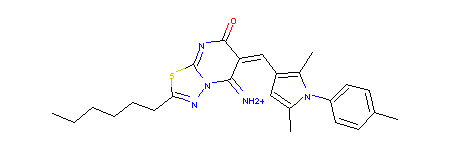

In [11]:
# beta=0
Chem.MolFromSmiles(reconstruct(model=model0, smile=smiles[smile_idx], seed=1, temp=1, print_stats=True))

For the model trained with $\beta=0.01$, the mean and variances are closer to $(0, 1)$: 

--- Summary statistics for latent distributions ---
Tree latents: average mean=1.876, average variance=0.054
Mol latents: average mean=0.420, average variance=0.423


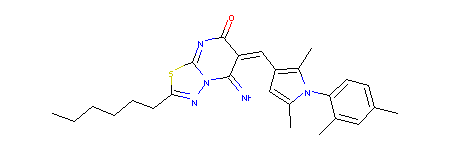

In [12]:
# beta=0.01
Chem.MolFromSmiles(reconstruct(model=model0_01, smile=smiles[smile_idx], seed=1, temp=1, print_stats=True))

If we turn the sampling temperature way up, it gives a different reconstructed molecule for the $\beta=0.01$ model. Since the variance is 0 for the model with $\beta=0$, reconstruction is less sensitive to the sampling temperature. 

--- Summary statistics for latent distributions ---
Tree latents: average mean=1.876, average variance=0.054
Mol latents: average mean=0.420, average variance=0.423


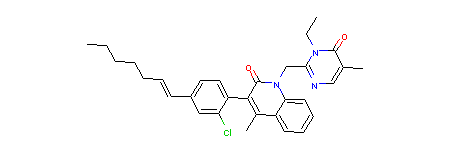

In [13]:
# beta=0.01
Chem.MolFromSmiles(reconstruct(model=model0_01, smile=smiles[smile_idx], seed=1, temp=10, print_stats=True))

--- Summary statistics for latent distributions ---
Tree latents: average mean=10.817, average variance=0.000
Mol latents: average mean=0.281, average variance=0.001


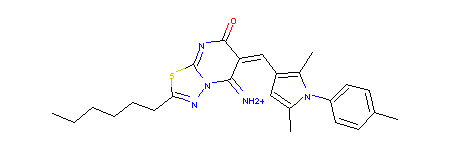

In [14]:
# beta=0
Chem.MolFromSmiles(reconstruct(model=model0, smile=smiles[smile_idx], seed=1, temp=100, print_stats=True))

The `sample_prior` function draws `z_tree_vecs` and `z_mol_vecs` from $\mathcal N(\mathbf{0}^d,\mathbf{I}^{d\times d})$. The latent distributions for the model trained with $\beta=0$ are really different from $\mathcal N(\mathbf{0}^d,\mathbf{I}^{d\times d})$, so it can't generate a molecule with high likelihood under the training distribution. On the other hand, the model with $\beta=0.01$ generates a much better looking molecule, since the latents for the training data are closer in distribution to $\mathcal N(\mathbf{0}^d,\mathbf{I}^{d\times d})$.

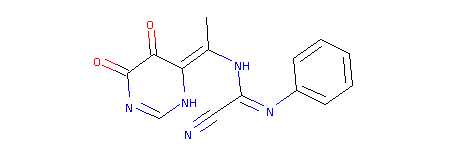

In [15]:
# beta=0.01
torch.manual_seed(1)
Chem.MolFromSmiles(model0_01.sample_prior())

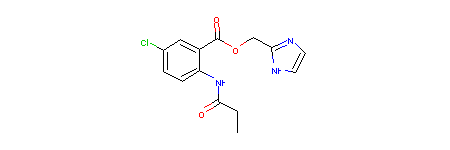

In [16]:
# beta=0.01
torch.manual_seed(2)
Chem.MolFromSmiles(model0_01.sample_prior())

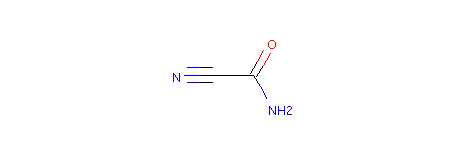

In [17]:
# beta=0
torch.manual_seed(1)
Chem.MolFromSmiles(model0.sample_prior())

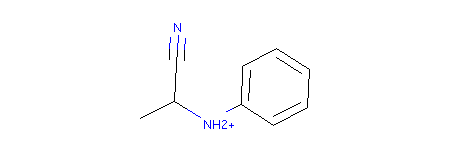

In [18]:
# beta=0
torch.manual_seed(2)
Chem.MolFromSmiles(model0.sample_prior())

In [19]:
# function for generating a new molecule by averaging the latents for reference molecules
#
# smiles is the list of smiles strings to be mixed together
# seed is a random seed for controlling randomness
# temp is the sampling temperature
# alpha is the mixing weights for each molecule; should be a list with the same length as smiles
# if alpha is not provided, uniform weights are used
def mix(model, smiles: list, seed: int, temp: float, alpha: list=None):

  # make sure alpha is a valid probability distribution
  alpha = torch.tensor(alpha).float() if alpha is not None else torch.ones(len(smiles))
  assert len(alpha) == len(smiles)
  alpha = (alpha.abs()/alpha.abs().sum()).reshape(-1, 1).to(device)

  model.eval()
  with torch.no_grad():
    if seed is not None:
      torch.manual_seed(seed)

    # y is the vector which determines the latent distributions
    y = model.encode_from_smiles(smiles)
    tree_vecs, mol_vecs = y.chunk(2, dim=1)

    # draw sample from latent distributions of each molecule (z_tree_vecs and z_mol_vecs)
    z_tree_vecs,tree_stats = rsample(tree_vecs, model.T_mean, model.T_var, temp, False)
    z_mol_vecs,mol_stats = rsample(mol_vecs, model.G_mean, model.G_var, temp, False)
    
    # average over the samples using alpha 
    z_tree_vecs, z_mol_vecs = (z_tree_vecs * alpha).sum(dim=0)[None], (z_mol_vecs * alpha).sum(dim=0)[None]

    # pass the sample through the decoder
    generated_smile = model.decode(z_tree_vecs, z_mol_vecs, prob_decode=False)
    
    return generated_smile

We will now recommend a new molecule based on these two reference molecules:

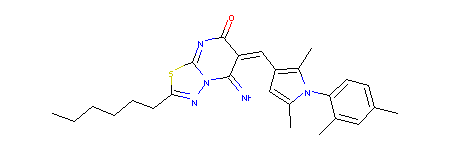

In [20]:
ref0, ref1 = 0, 3
ref_mols = [smiles[ref0], smiles[ref1]]
Chem.MolFromSmiles(ref_mols[0])

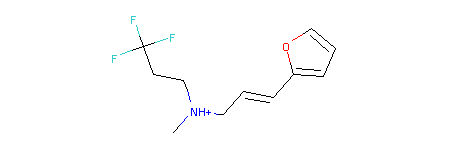

In [21]:
Chem.MolFromSmiles(ref_mols[1])

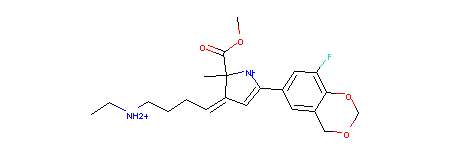

In [22]:
Chem.MolFromSmiles(mix(model=model0_01, smiles=ref_mols, seed=1, temp=1))

We can recommend a different molecule by changing the random seed or the sampling temperature.

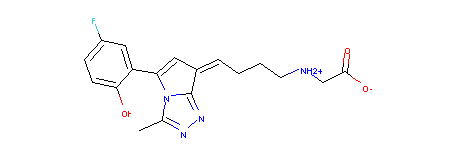

In [23]:
Chem.MolFromSmiles(mix(model=model0_01, smiles=ref_mols, seed=2, temp=1))

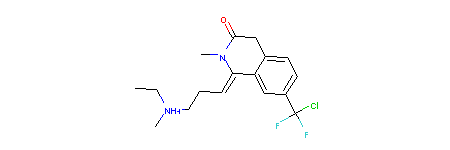

In [24]:
Chem.MolFromSmiles(mix(model=model0_01, smiles=ref_mols, seed=2, temp=2))

We can also change the averaging weights. Since previously the weights weren't provided, the weights were 0.5 and 0.5 by default. Setting them to 0 and 1 will place all weight on the second molecule, making it so that the second molecule is reconstructed.

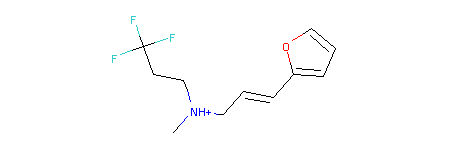

In [25]:
Chem.MolFromSmiles(mix(model=model0_01, smiles=ref_mols, seed=1, temp=1, alpha=[0, 1]))

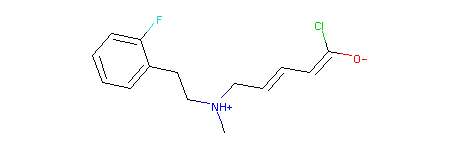

In [26]:
Chem.MolFromSmiles(mix(model=model0_01, smiles=ref_mols, seed=1, temp=1, alpha=[0.15, 0.85]))